’’’’<br/>

<img src="https://uploads-ssl.webflow.com/614b1fe22fa8b90ef41aeffe/6265cb48f9496b1cefc9ab75_logotipo-mbit-39.png" width="200px" align="right" CLASS="TextWrap" style="background-color:#2a3f3f;">

<h1><font color="#2a3f3f" size=5></font></h1>

<br/>
<div style="text-align: right">
<font color="#2a3f3f" size=3>Javier Cózar - javier.cozar@mbitschool.com</font><br>
<font color="#2a3f3f" size=3>M07 - Proyecto de consolidación</font><br>
</div>


En este proyecto de consolidación vamos a aprender un modelo de detección del sentimiento utilizando MLlib. Una vez aprendido serializaremos el modelo en S3, lo que nos permitirá realizar predicciones siempre que queramos leyendo el modelo serializado con una simple instrucción.

Para ello utilizaremos el dataset de [__amazon reviews__](https://s3.amazonaws.com/amazon-reviews-pds/readme.html) que antes estaba disponible de manera pública a través de un bucket de AWS S3, pero que han bloqueado el acceso por razones internas. En la siguiente URL podemos encontrar una versión del dataset público de amazon que contiene una gran cantidad de reviews generadas a lo largo de los años.

https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/

Puedes descargar el dataset original en la sección de **Files**. Sin embargo, para evitar descargar un dataset tan pesado, en la carpeta `data/amazon-reviews/` encontrarás un subset de los datos de la categoría `Electronics` en formato parquet. Debes subir esta carpeta a AWS S3 para poder trabajar con estos datos.

## Configuración de la sesión de glue

In [ ]:
%env AWS_ACCESS_KEY_ID=...
%env AWS_SECRET_ACCESS_KEY=...    #No pongo las credenciales porque se introducen en DataSpell en el txt de las credenciales
%env AWS_SESSION_TOKEN=...

In [10]:
%iam_role arn:aws:iam::730335631817:role/LabRole
%region us-east-1
%number_of_workers 2
%worker_type G.1X
%idle_timeout 120

Welcome to the Glue Interactive Sessions Kernel
For more information on available magic commands, please type %help in any new cell.

Please view our Getting Started page to access the most up-to-date information on the Interactive Sessions kernel: https://docs.aws.amazon.com/glue/latest/dg/interactive-sessions.html
It looks like there is a newer version of the kernel available. The latest version is 1.0.6 and you have 1.0.5 installed.
Please run `pip install --upgrade aws-glue-sessions` to upgrade your kernel
Current iam_role is None
iam_role has been set to arn:aws:iam::730335631817:role/LabRole.
Previous region: None
Setting new region to: us-east-1
Region is set to: us-east-1
Previous number of workers: None
Setting new number of workers to: 2
Previous worker type: None
Setting new worker type to: G.1X
Current idle_timeout is None minutes.
idle_timeout has been set to 120 minutes.


In [1]:
spark

Trying to create a Glue session for the kernel.
Session Type: etl
Worker Type: G.1X
Number of Workers: 2
Idle Timeout: 120
Session ID: a506606c-02b7-4188-bfeb-aceb5bec75fc
Applying the following default arguments:
--glue_kernel_version 1.0.5
--enable-glue-datacatalog true
Waiting for session a506606c-02b7-4188-bfeb-aceb5bec75fc to get into ready status...
Session a506606c-02b7-4188-bfeb-aceb5bec75fc has been created.


Importamos las librerías necesarias

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as f

Define el nombre de tu bucket de S3 aquí, donde subiremos los datos:

In [5]:
BUCKET_NAME = "pc4-mbit-pablolopez"

## Fase 1: Carga y análisis exploratorio

Cargar el dataset a partir de los ficheros parquet y verificar el esquema. Muestra también las primeras filas del mismo.

#### Carga los datos del bucket original

In [7]:
df = (
    spark
    .read
    .format("parquet")
    .load("s3://pc4-mbit-pablolopez/data/amazon-reviews/")
)

In [9]:
df.show()

+----------+-------+--------------------+--------------------+-----------+--------------+------------------+--------+----+-----------+
|      asin|overall|             summary|          reviewText| reviewTime|    reviewerID|      reviewerName|verified|vote|   category|
+----------+-------+--------------------+--------------------+-----------+--------------+------------------+--------+----+-----------+
|B00007E7JU|    4.0|        light sponge|Super cheap and s...| 09 5, 2009|A29IP2N2DSBH3T|Ben B. Photography|    true|null|electronics|
|B000068U29|    1.0|Display stopped w...|While it worked, ...| 11 3, 2003|A198CCH4NNLI2E|    Jonathan Birge|   false|null|electronics|
|B00004ZCKA|    1.0|  Very disappointed.|Had to send them ...|01 13, 2009|A2HQHL396BKNP6|         Geoffreyo|   false|   9|electronics|
|B00008BO8M|    5.0|           Excellent|This thing is fan...|01 28, 2008|A1IK26QYTPLDWG| Terry D. Anderson|    true|   8|electronics|
|B000092TT0|    5.0|               Great|Its pretty har

In [11]:
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- overall: double (nullable = true)
 |-- summary: string (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- vote: string (nullable = true)
 |-- category: string (nullable = true)


In [13]:
df.describe()

DataFrame[summary: string, asin: string, overall: string, summary: string, reviewText: string, reviewTime: string, reviewerID: string, reviewerName: string, vote: string, category: string]


#### Cuenta el total de elementos

In [14]:
df.count()

599973


### Análisis exploratorio

Resuelve las siguientes cuestiones haciendo queries y también de manera gráfica

- Muestra el total de reviews para cada posible número de estrellas recibidas (`overall`)

In [15]:
df_count = (
    df
    .groupBy("overall")
    .count()
)

In [16]:
df_count.show()

+-------+------+
|overall| count|
+-------+------+
|    4.0|101991|
|    1.0| 39868|
|    3.0| 44377|
|    5.0|386898|
|    2.0| 26839|
+-------+------+


In [17]:
df_count_graf = df_count.toPandas()

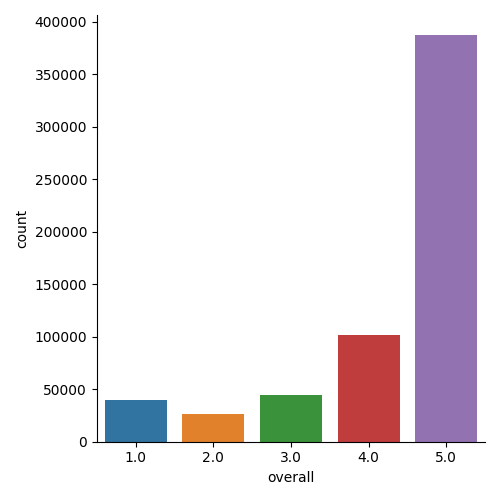

In [18]:
sns.catplot(data=df_count_graf,kind="bar",x="overall",y="count")
%matplot plt

- Obtén los 10 productos (columna `asin`) con más reviews mostrando numero de votos y valoración media

In [20]:
df_top10 = (
    df
    .groupBy("asin")
    .agg(
        f.sum("vote").alias("total_votes"),
        f.mean("overall").alias("mean_overall")
    )
    .orderBy
    (f.desc("total_votes"))
    .limit(10)
)

In [22]:
df_top10.show()

+----------+-----------+------------------+
|      asin|total_votes|      mean_overall|
+----------+-----------+------------------+
|B00112DQXO|     1944.0|           4.68125|
|B0012YFY54|     1647.0|               4.6|
|B0099XGZXA|     1315.0|3.8275862068965516|
|B00752R9SW|     1279.0| 4.523809523809524|
|B0007U00XA|     1124.0| 4.484848484848484|
|B00FB45SI4|     1083.0| 4.163157894736842|
|B00IEZGWI2|     1051.0| 4.086956521739131|
|B000V1XLNG|     1023.0|               4.0|
|B006U1VH2S|     1014.0| 4.282051282051282|
|B00RKNND2W|     1004.0|               4.0|
+----------+-----------+------------------+


In [23]:
df_top10_graf = df_top10.toPandas()

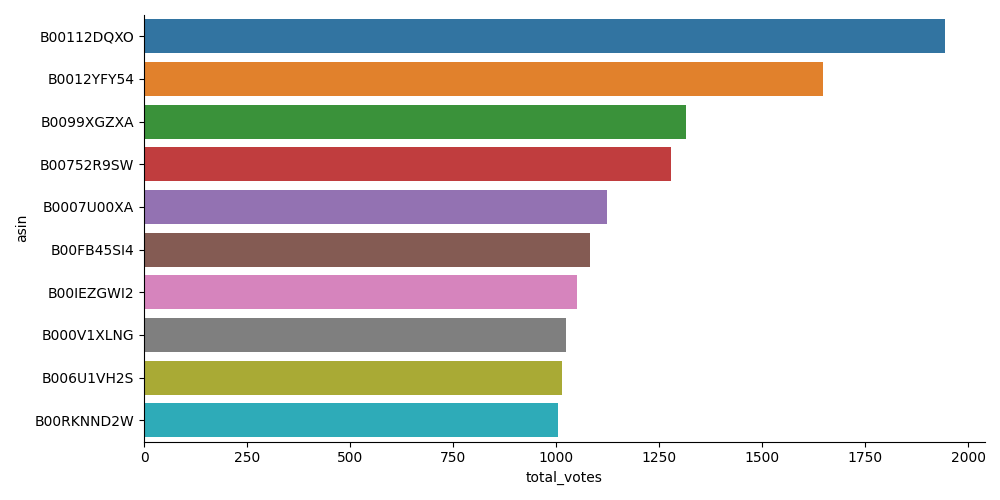

In [25]:
sns.catplot(data=df_top10_graf,kind="bar",x="total_votes",y="asin", aspect=2)
%matplot plt

- Obtén la cantidad de reviews por mes y año y su valoración media

In [27]:
df_fechas = (
    df
    .withColumn(
        "reviewTime", f.to_date("reviewTime", "MM d, yyyy")
    )
    
    .withColumn(
        "year", f.year("reviewTime")
    )
    
    .withColumn(
        "month", f.month("reviewTime")
    )
    
    .groupBy("year", "month")
    
    .agg(
        f.count("asin").alias("total_reviews"),
        f.mean("overall").alias("mean_overall")
    )
    .orderBy(["year", "month"], ascending=[False, False])
).show()

+----+-----+-------------+------------------+
|year|month|total_reviews|      mean_overall|
+----+-----+-------------+------------------+
|2018|    9|           88| 4.056818181818182|
|2018|    8|          620| 4.174193548387096|
|2018|    7|         1408| 4.279829545454546|
|2018|    6|         2056| 4.320525291828794|
|2018|    5|         2844|4.3048523206751055|
|2018|    4|         3649| 4.339545080844067|
|2018|    3|         4309| 4.324669296820608|
|2018|    2|         4118| 4.315930063137445|
|2018|    1|         4904| 4.308727569331158|
|2017|   12|         4374| 4.256515775034294|
|2017|   11|         4344| 4.272329650092081|
|2017|   10|         4562| 4.266768960982025|
|2017|    9|         4761| 4.306448225162781|
|2017|    8|         5536| 4.297145953757226|
|2017|    7|         5638| 4.276516495211068|
|2017|    6|         5477| 4.308015336863246|
|2017|    5|         5959|  4.31767075012586|
|2017|    4|         6671| 4.336831059811122|
|2017|    3|         8323| 4.34650

In [28]:
df_fechas2 = (
    df
    .withColumn("date", f.to_date("reviewTime", "MM d, yyyy"))
    .withColumn('year', f.year('date'))
    .withColumn('month', f.month('date'))
    #.withColumn("year_month", f.concat(f.col('year'),f.lit('-'), f.col('month')))
    .withColumn("year_month", f.date_format('date', 'yyyy-MM'))
    .groupBy("year_month")
    .agg(
        f.count("asin").alias("n_reviews"), f.avg("overall").alias("avg_votes"))
    .orderBy("n_reviews", ascending=False)
    .limit(10)
) #.show

In [30]:
df_fechas2_graf = df_fechas2.toPandas()

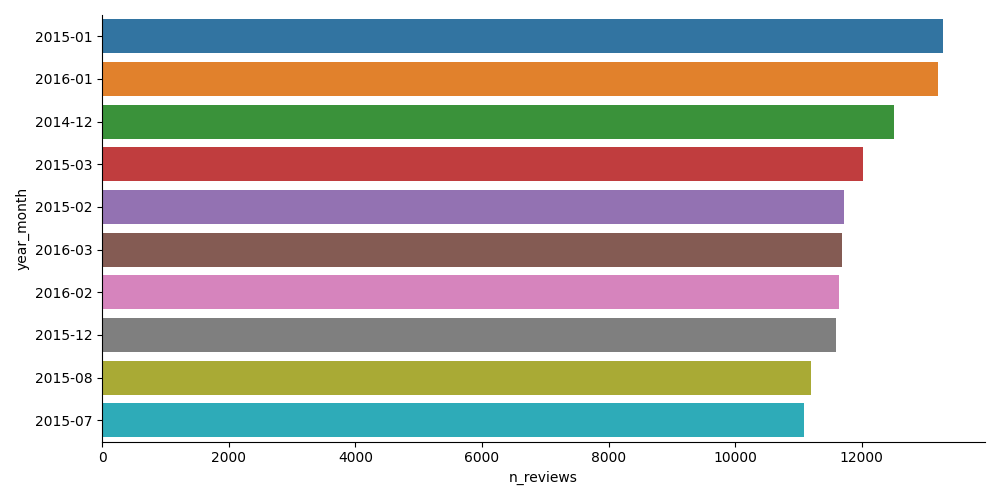

In [31]:
sns.catplot(kind="bar", data=df_fechas2_graf, y="year_month", x="n_reviews", aspect=2)
%matplot plt

## Fase 2: Limpieza

Antes de proseguir con el modelado realizaremos dos procesos de limpieza sobre los datos:

- Limpiamos el texto de las reviews utilizando expresiones sobre strings o expresiones regulares
    - Pasar todo el texto a minusculas
    - Eliminar números y signos de puntuacion

- Crearemos la variable `sentiment` en función del número de estrellas asumiendo que una review de menos de 3 estrellas es negativa, para poder generar la variable que determine el sentiment a partir del número de estrellas podéis utilizar la función de spark `when` 

- Visualiza el resultado estudiando alguna review suelta con su numero de estrellas correspondiente

In [33]:
df

DataFrame[asin: string, overall: double, summary: string, reviewText: string, reviewTime: string, reviewerID: string, reviewerName: string, verified: boolean, vote: string, category: string]


In [35]:
(df.filter(f.col("reviewText").isNull())).show()

+----------+-------+-----------+----------+-----------+--------------+--------------------+--------+----+-----------+
|      asin|overall|    summary|reviewText| reviewTime|    reviewerID|        reviewerName|verified|vote|   category|
+----------+-------+-----------+----------+-----------+--------------+--------------------+--------+----+-----------+
|B00004ZCJI|    5.0| Five Stars|      null| 09 6, 2015|A322CBQ9W93ZUZ|              marcos|    true|null|electronics|
|B0002J1WTC|    2.0|  Two Stars|      null|11 12, 2015|A2LLTQB7Z93WY8|         NICK EREDIA|   false|null|electronics|
|B0012YLTR6|    5.0| Five Stars|      null|06 15, 2016| AJECPCOLT4S8Y|                 Lar|    true|null|electronics|
|B003INFE16|    5.0|Pretty cool|      null|01 13, 2018|A1RHX3YPRXLB70|               Tails|    true|null|electronics|
|B00529MQVU|    5.0|       null|      null| 02 8, 2017|A2WB7MWYML9JZM|            Adrian g|    true|null|electronics|
|B005QX7KYU|    1.0| didnt work|      null|11 11, 2015|A

In [36]:
(df.filter(f.col("reviewText").isNull()).count())

102


In [37]:
df_limpieza = (df.filter(f.col('reviewText').isNotNull()))

In [38]:
df_limpieza.show()

+----------+-------+--------------------+--------------------+-----------+--------------+------------------+--------+----+-----------+
|      asin|overall|             summary|          reviewText| reviewTime|    reviewerID|      reviewerName|verified|vote|   category|
+----------+-------+--------------------+--------------------+-----------+--------------+------------------+--------+----+-----------+
|B00007E7JU|    4.0|        light sponge|Super cheap and s...| 09 5, 2009|A29IP2N2DSBH3T|Ben B. Photography|    true|null|electronics|
|B000068U29|    1.0|Display stopped w...|While it worked, ...| 11 3, 2003|A198CCH4NNLI2E|    Jonathan Birge|   false|null|electronics|
|B00004ZCKA|    1.0|  Very disappointed.|Had to send them ...|01 13, 2009|A2HQHL396BKNP6|         Geoffreyo|   false|   9|electronics|
|B00008BO8M|    5.0|           Excellent|This thing is fan...|01 28, 2008|A1IK26QYTPLDWG| Terry D. Anderson|    true|   8|electronics|
|B000092TT0|    5.0|               Great|Its pretty har

In [84]:
df_limpieza = df_limpieza.withColumn("clean_text",  f.lower(f.regexp_replace("reviewText", r'[^a-zA-Z\s]', ' '’’’’

In [85]:
df_limpieza.show()

+----------+-------+--------------------+--------------------+-----------+--------------+------------------+--------+----+-----------+--------------------+---------+
|      asin|overall|             summary|          reviewText| reviewTime|    reviewerID|      reviewerName|verified|vote|   category|          clean_text|sentiment|
+----------+-------+--------------------+--------------------+-----------+--------------+------------------+--------+----+-----------+--------------------+---------+
|B00007E7JU|    4.0|        light sponge|Super cheap and s...| 09 5, 2009|A29IP2N2DSBH3T|Ben B. Photography|    true|null|electronics|super cheap and s...|        1|
|B000068U29|    1.0|Display stopped w...|While it worked, ...| 11 3, 2003|A198CCH4NNLI2E|    Jonathan Birge|   false|null|electronics|while it worked  ...|        0|
|B00004ZCKA|    1.0|  Very disappointed.|Had to send them ...|01 13, 2009|A2HQHL396BKNP6|         Geoffreyo|   false|   9|electronics|had to send them ...|        0|
|B00

In [86]:
df_limpieza = df_limpieza.withColumn("sentiment", f.when(f.col('overall') >= 3, 1).when(f.col('overall') < 3, 0))

In [87]:
df_limpieza.show()

+----------+-------+--------------------+--------------------+-----------+--------------+------------------+--------+----+-----------+--------------------+---------+
|      asin|overall|             summary|          reviewText| reviewTime|    reviewerID|      reviewerName|verified|vote|   category|          clean_text|sentiment|
+----------+-------+--------------------+--------------------+-----------+--------------+------------------+--------+----+-----------+--------------------+---------+
|B00007E7JU|    4.0|        light sponge|Super cheap and s...| 09 5, 2009|A29IP2N2DSBH3T|Ben B. Photography|    true|null|electronics|super cheap and s...|        1|
|B000068U29|    1.0|Display stopped w...|While it worked, ...| 11 3, 2003|A198CCH4NNLI2E|    Jonathan Birge|   false|null|electronics|while it worked  ...|        0|
|B00004ZCKA|    1.0|  Very disappointed.|Had to send them ...|01 13, 2009|A2HQHL396BKNP6|         Geoffreyo|   false|   9|electronics|had to send them ...|        0|
|B00

In [88]:
df_prueba = df_limpieza.toPandas()

In [100]:
df_prueba.iloc[33]

asin                                                   B00004ZCJJ
overall                                                       5.0
summary                                            Nice and clear
reviewText      I bought this mostly to protect my lens and it...
reviewTime                                            06 13, 2014
reviewerID                                          AKTRVGP0A92BR
reviewerName                                                 Pete
verified                                                     True
vote                                                         None
category                                              electronics
clean_text      i bought this mostly to protect my lens and it...
sentiment                                                       1
Name: 33, dtype: object


In [102]:
df_prueba.iloc[33].clean_text

'i bought this mostly to protect my lens and it works great  i was inexpensive but the quality fits my needs'


### Sampling

Los datos están desbalanceados y el número de instancias es demasiado elevado. Para poderlo resolver vamos a realizar dos procesos:

- Utiliza la función `sample_by` para muestrear el dataset y que quede el mismo número de elementos para cada clase.
- Reduce el número de instancias para que haya en torno a 100k utiliza un nuevo muestreo o realizado junto con el anterior

In [104]:
df_limpieza = (
    df_limpieza.select("sentiment", "clean_text")
    .sampleBy("sentiment", fractions = {0: 1.0,1: 0.2}) .sample(0.1) .cache()
)

## Fase 3: Modelado

A continuación vamos a entrenar el modelo, para ello utilizaremos diferentes opciones de preprocesamiento

Para poder entrenar un clasificador de sentimiento necesitamos contruir una representación del texto que nos permita entrenar el modelo. Para ello utilizaremos un algoritmo de embedding como Word2Vec que viene implementado en Spark MLlib y que nos permitirá transformar una cadena de texto a un vector para utilizarlo como datos de entrenamiento de un clasificador. Este modelo viene definido como una serie de **transformadores** y **estimadores**

- `Tokenizer` nos permitirá construir un vector de palabras a partir de nuestras sentencias
- `StopWordsRemover` nos permitirá limpiar de nuestros vectores de palabras las de menor significado

- Construcción de características dos alternativas
    -  Modelo TF-IDF usando `HashingTF` e `IDF`
    - `Word2Vec` nos permitirá crear un vector a partir de la lista de palabras

- Clasificación binaria, basada en la variable sentiment que hemos utilizado, aplica un clasificador (LogisticRegregession, DecisionTree) evita ensembles por su alto tiempo de aprendizaje.

Buscando en la documentación, encuentra los distintos elementos y conectalos en un pipeline junto a un algorimo de clasificación

- Recomiendo utilizar una muestra pues el tiempo puede ser excesivo
- Es posible ajustar hiperparámetros, pero igualmente puede ser bastante caro

In [264]:
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, Word2Vec
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.model_selection import ParameterGrid

In [266]:
tokenizer = Tokenizer(inputCol = "clean_text", outputCol = "clean_text_token")
remover = StopWordsRemover(inputCol = tokenizer.getOutputCol(), outputCol = "clean_text_tokens_improved")

word2Vec = Word2Vec(minCount = 5, vectorSize = 200, inputCol = remover.getOutputCol(), outputCol = "features")

In [268]:
train, test = df_limpieza.randomSplit([0.8, 0.2], seed = 2022)

In [270]:
# Para analizar cuál es el mejor modelo posible, se analiza con diversos hiperparámetros
paramGrid = {
    'regParam': [0.01, 0.1, 1.0],
    'maxIter': [10, 20, 50]
}

In [288]:
best_model = None
best_accuracy = 0

for params in ParameterGrid(paramGrid):

    model = LogisticRegression(regParam = params['regParam'], maxIter = params['maxIter']).setFeaturesCol('features').setLabelCol('sentiment') # Configuramos el modelo de regresión logística con los hiperparámetros actuales
    pipeline = Pipeline(stages = [tokenizer, remover, word2Vec, model]) # se crea el pipeline

    # entrenamos el modelo y realizamos las predicciones
    model_pipeline = pipeline.fit(train)
    predictions = model_pipeline.transform(test)

    # se evalúa
    evaluator = MulticlassClassificationEvaluator(labelCol = "sentiment", metricName = "accuracy")
    accuracy = evaluator.evaluate(predictions)

    # y se guarda el mejor modelo
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model_pipeline

# y obtenemos las métricas de este
predictions = best_model.transform(test)
evaluator1 = MulticlassClassificationEvaluator(labelCol = "sentiment", metricName = "accuracy")
print(f"Best Model Accuracy: {evaluator1.evaluate(predictions)}")
evaluator2 = BinaryClassificationEvaluator(labelCol = "sentiment", metricName = "areaUnderROC")
print(f"Best Model AUC: {evaluator2.evaluate(predictions)}")

Best Model Accuracy: 0.8204545454545454
Best Model AUC: 0.889854639818398


## Fase 4: Serializacion


Una vez aprendido el modelo almacénalo en S3 utilizando tanto opción nativa de spark y así poderlo utilizar en el futuro.

Finalmente, carga el modelo a partir de los datos serializados y haz una predicción sobre los datos de test.

In [290]:
sc._jsc.hadoopConfiguration().set("mapred.output.committer.class", "org.apache.hadoop.mapred.DirectFileOutputCommitter")

In [294]:
best_model.write().overwrite().save(f"s3://{BUCKET_NAME}/modelos/sentiment_model")
model_b = PipelineModel.load(f"s3://{BUCKET_NAME}/modelos/sentiment_model/")

In [296]:
predictions = model_b.transform(test)
predictions.show()

+---------+--------------------+--------------------+--------------------------+--------------------+--------------------+--------------------+----------+
|sentiment|          clean_text|    clean_text_token|clean_text_tokens_improved|            features|       rawPrediction|         probability|prediction|
+---------+--------------------+--------------------+--------------------------+--------------------+--------------------+--------------------+----------+
|        0|    for a single ...|[, , , , for, a, ...|      [, , , , single, ...|[0.02050358503280...|[-0.4480469652704...|[0.38982521776890...|       1.0|
|        0|  of the camera s...|[, , of, the, cam...|      [, , camera, infr...|[-0.0076047458592...|[0.99549293164919...|[0.73017151292253...|       0.0|
|        0| div id  video bl...|[, div, id, , vid...|      [, div, id, , vid...|[-0.0019399552711...|[-0.4175254925908...|[0.39710902938745...|       1.0|
|        0| i am adjusting t...|[, i, am, adjusti...|      [, adjustin

## Opcional

Con la columna de predictions y de sentiments, prueba a quedarte con unas cuantas filas que la predicción sea erronea (sentiment distinto de prediction), recolectalas con Pandas para una evaluación más cómoda y visualiza los textos. ¿Tienen sentido? :-)

In [300]:
incorrect_predictions = predictions.filter(predictions.sentiment != predictions.prediction)
incorrect_predictions_df = incorrect_predictions.select("clean_text", "sentiment", "prediction").toPandas()


print(incorrect_predictions_df.head(10))

            # para ver los textos asociados y evaluar la precisión del modelo
for index, row in incorrect_predictions_df.head(10).iterrows():
    print(f"Texto: {row['clean_text']}")
    print(f"Sentimiento Real: {row['sentiment']}, Predicción: {row['prediction']}")
    print("-" * 80)

                                          clean_text  sentiment  prediction
0      for a single   foot off brand cable  what ...          0         1.0
1   div id  video block r h sj  evba y  class  a ...          0         1.0
2              a bit small  no cover for protection           0         1.0
3  after about   hours of use the bulb pretty muc...          0         1.0
4  any high tones are too loud and get distorted ...          0         1.0
5                               apps are pretty slow          0         1.0
6  arrived appearing new but red channel is broke...          0         1.0
7  collee students should not have to buy these  ...          0         1.0
8                  did not function between two tv s          0         1.0
9                               didnt fir  too stiff          0         1.0
Texto:     for a single   foot off brand cable  what a deal   
Sentimiento Real: 0, Predicción: 1.0
----------------------------------------------------------------

Está claro que hay fallas en el modelo, pero dentro de ellas podemos encontrar desde:
- Personas que aunque hacen la reseña negativa, la reseña sigue siendo de 3 o más estrellas
- Otros que hacen justo lo inverso
- Las faltas de ortografía hacen que el modelo cometa más errores 
- Pero especialmente, las frases irónicas y sarcásticas son las que más confunden al modelo, calificando negativamente de forma sarcástica y el modelo lo entiende positivo.